In [2]:
!pip install ultralytics -q

In [4]:
!pip install datasets -q

In [2]:
from ultralytics import YOLO
from datasets import load_dataset
import os
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
from huggingface_hub import login # Import the login function from huggingface_hub

# Authenticate with your Hugging Face token
login() # This will prompt you to enter your token if you haven't already logged in.

# Carregar o dataset
dataset = load_dataset("gabraken/mtg-detection")

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/45 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/34 [00:00<?, ?it/s]

In [3]:
# Exibir informações do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'annotation', 'metadata'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['id', 'image', 'annotation', 'metadata'],
        num_rows: 3000
    })
})


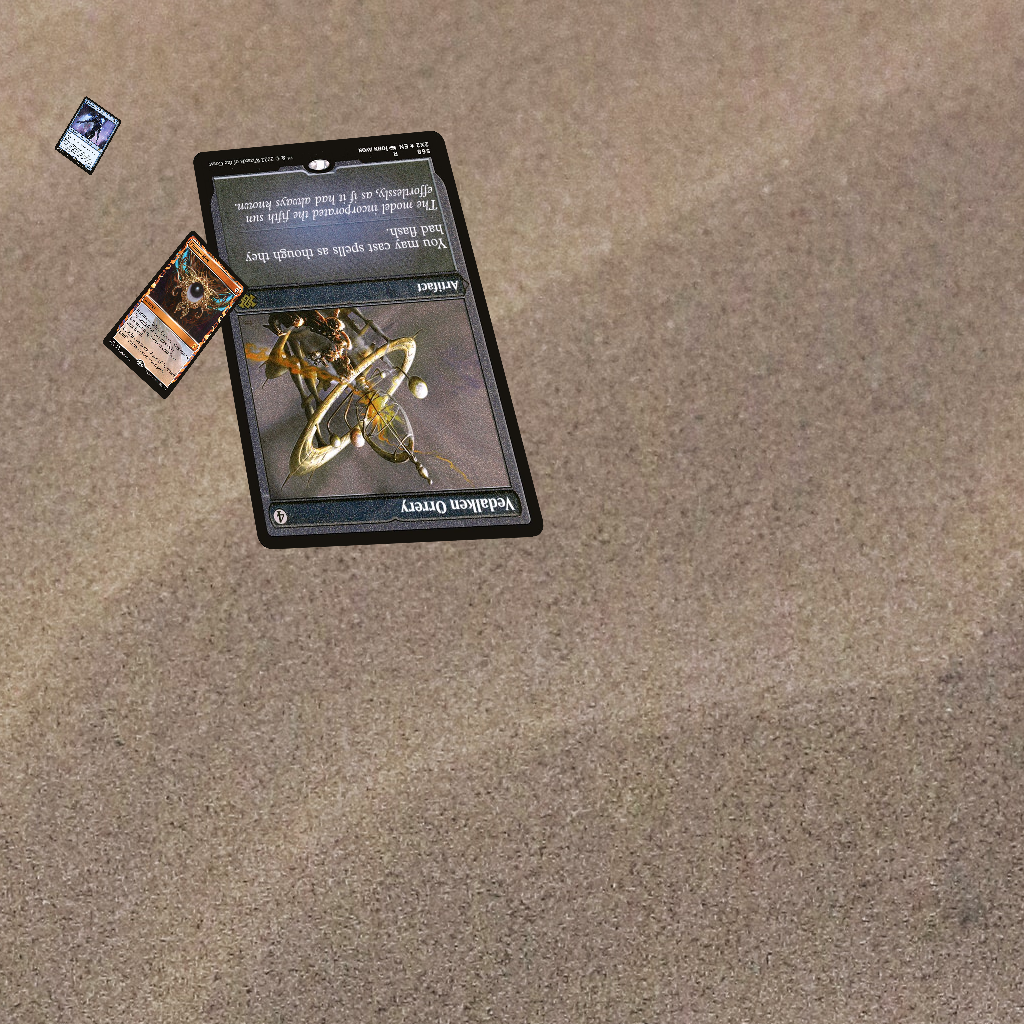

[[1.4711688358816655, 1.3712258836823217, 0.0, 1.0317013974568106, 0.0], [1.857718087022326, 2.0174131834762763, 0.0, -0.5572083588829879, 1.0], [2.3231806509799857, 1.7273986432423765, 0.0, -2.0966823584542373, 2.0], [1.9455060052069968, 1.0766886936348357, 0.0, 2.5859147665110265, 3.0], [0.5163012049403285, 0.5086607924726627, 1.0, -1.8208303490518927, 0.0], [0.42183668615881154, 0.13876025739260742, 1.0, 3.050200912815511, 1.0], [0.19931613069804455, 0.1591536081044753, 1.0, 1.3965870255978714, 2.0], [0.26301968199124964, 0.5211193549313504, 1.0, -0.04914898240517035, 3.0], [0.08379472477556581, 0.09568078765174974, 1.0, 2.1085899987606282, 0.0], [0.0549239767612685, 0.14408635246769036, 1.0, 0.631518595115332, 1.0], [0.087825324744319, 0.16815181978821872, 1.0, -1.053987617992515, 2.0], [0.11608698221429431, 0.11842445198760451, 1.0, -2.5279819017977974, 3.0], [0.187307642634085, 0.2293675528545099, 1.0, 2.2472113215554184, 0.0], [0.10456060255840074, 0.3324471289435243, 1.0, 0.742

In [7]:
# Selecionar uma amostra do dataset
sample = dataset['train'][20]

# Carregar a imagem
image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)

# Exibir a imagem
cv2_imshow(image)

# Exibir anotações
print(sample['annotation'])


In [4]:
#Treino

import os
import cv2
import numpy as np

# Criação de diretórios
os.makedirs('datasets/data/images/train', exist_ok=True)
os.makedirs('datasets/data/labels/train', exist_ok=True)

# Agrupa os pontos de cada carta com base no corner_id == 0
def group_cards(annotation):
    cards = []
    i = 0
    while i < len(annotation):
        if int(annotation[i][4]) == 0:  # início de nova carta
            card = [annotation[i]]
            for j in range(1, 4):
                if i + j < len(annotation) and int(annotation[i + j][4]) == j:
                    card.append(annotation[i + j])
            if len(card) == 4:
                cards.append(card)
            i += 4
        else:
            i += 1
    return cards

# Converte uma imagem + anotação para arquivos de treino YOLO OBB (Oriented Bounding Box)
def convert_annotation(sample, idx):
    image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
    image_path = f'datasets/data/images/train/{idx}.jpg'
    label_path = f'datasets/data/labels/train/{idx}.txt'
    h, w = image.shape[:2]
    cv2.imwrite(image_path, image)

    cards = group_cards(sample['annotation'])

    with open(label_path, 'w') as f:
        for card in cards:
            if len(card) != 4:
                continue
            # Pega os 4 pontos normalizados (x, y)
            points = [(min(p[0], 1.0), min(p[1], 1.0)) for p in card]
            coords = [f"{x:.6f} {y:.6f}" for x, y in points]
            f.write("0 " + " ".join(coords) + "\n")  # classe 0

# Aplicar ao conjunto de treino
for idx, sample in enumerate(dataset['train']):
    convert_annotation(sample, idx)
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [5]:
#Teste

import os
import cv2
import numpy as np

# Criação de diretórios
os.makedirs('datasets/data/images/test', exist_ok=True)
os.makedirs('datasets/data/labels/test', exist_ok=True)

# Agrupa os pontos de cada carta com base no corner_id == 0
def group_cards(annotation):
    cards = []
    i = 0
    while i < len(annotation):
        if int(annotation[i][4]) == 0:  # início de nova carta
            card = [annotation[i]]
            for j in range(1, 4):
                if i + j < len(annotation) and int(annotation[i + j][4]) == j:
                    card.append(annotation[i + j])
            if len(card) == 4:
                cards.append(card)
            i += 4
        else:
            i += 1
    return cards

# Converte uma imagem + anotação para arquivos de treino YOLO OBB (Oriented Bounding Box)
def convert_annotation(sample, idx):
    image = cv2.imdecode(np.frombuffer(sample['image'], np.uint8), cv2.IMREAD_COLOR)
    image_path = f'datasets/data/images/test/{idx}.jpg'
    label_path = f'datasets/data/labels/test/{idx}.txt'
    h, w = image.shape[:2]
    cv2.imwrite(image_path, image)

    cards = group_cards(sample['annotation'])

    with open(label_path, 'w') as f:
        for card in cards:
            if len(card) != 4:
                continue
            # Pega os 4 pontos normalizados (x, y)
            points = [(min(p[0], 1.0), min(p[1], 1.0)) for p in card]
            coords = [f"{x:.6f} {y:.6f}" for x, y in points]
            f.write("0 " + " ".join(coords) + "\n")  # classe 0

# Aplicar ao conjunto de treino
for idx, sample in enumerate(dataset['test']):
    convert_annotation(sample, idx)
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
yaml_content = """
train: data/images/train
val: data/images/train  # ou datasets/data/images/val se tiver separado

nc: 1  # número de classes
names: ["card"]  # nome da(s) classe(s)

# Para YOLO com caixas rotacionadas (OBB)
obb: true
"""

with open("mtg.yaml", "w") as f:
    f.write(yaml_content)

In [1]:
!head datasets/data/labels/train/3367.txt

0 1.000000 1.000000 0.554758 1.000000 0.965663 1.000000 1.000000 1.000000
0 0.100405 0.121821 0.035283 0.104208 0.024190 0.146819 0.088391 0.164976
0 0.626030 0.713360 0.966120 0.913518 1.000000 0.683224 0.777045 0.479922


In [10]:
!rm -rf /content/datasets/data

In [ ]:
#Treinar modelo
from ultralytics import YOLO

data_yaml = 'mtg.yaml'

model = YOLO('yolo11n-obb.pt')  # você pode trocar por 'yolov8s-obb.pt', 'yolov8m-obb.pt', etc.
model.train(
    data=data_yaml,
    epochs=30,
    imgsz=640,
    batch=-1,
    name='yolo_cards_obb',
    device='cuda')

Ultralytics 8.3.102  Python-3.13.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=obb, mode=train, model=yolo11n-obb.pt, data=mtg.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolo_cards_obb4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning E:\IA-FRONT\datasets\data\labels\train.cache... 10000 images, 0 backgrounds, 140 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

train: WARNING  E:\IA-FRONT\datasets\data\images\train\1005.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1006.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1032.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1035.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1039.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.098658]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1046.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.129408]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1056.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1081.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1086.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1

AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU) 4.00G total, 0.27G reserved, 0.18G allocated, 3.55G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2661702       6.688         0.512         99.34           nan        (1, 3, 640, 640)                    list
     2661702       13.38         0.948            86           nan        (2, 3, 640, 640)                    list
     2661702       26.75         1.619         131.7           nan        (4, 3, 640, 640)                    list
     2661702       53.51         2.951         69.54           nan        (8, 3, 640, 640)                    list
     2661702         107         5.530         86.84           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 5 for CUDA:0 2.44G/4.00G (61%) 


train: Scanning E:\IA-FRONT\datasets\data\labels\train.cache... 10000 images, 0 backgrounds, 140 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

train: WARNING  E:\IA-FRONT\datasets\data\images\train\1005.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1006.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1032.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1035.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1039.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.098658]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1046.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.129408]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1056.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1081.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1086.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1


val: Scanning E:\IA-FRONT\datasets\data\labels\train.cache... 10000 images, 0 backgrounds, 140 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

train: WARNING  E:\IA-FRONT\datasets\data\images\train\1005.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1006.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1032.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1035.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1039.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.098658]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1046.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.129408]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1056.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1081.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1086.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1

Plotting labels to runs\obb\yolo_cards_obb4\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 87 weight(decay=0.0), 97 weight(decay=0.0005078125), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\obb\yolo_cards_obb4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30     0.832G      1.001      1.063      1.817         14        640: 100%|██████████| 1972/1972 [06:24<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:51<00:00,  8.53it/s]


                   all       9860      31168      0.956      0.615       0.65      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30     0.877G     0.8941     0.7557      1.775         27        640: 100%|██████████| 1972/1972 [05:49<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:02<00:00, 10.79it/s]


                   all       9860      31168      0.935       0.62      0.654      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30     0.877G     0.8675      0.727      1.767         15        640: 100%|██████████| 1972/1972 [05:10<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:05<00:00, 10.61it/s]


                   all       9860      31168       0.95      0.619      0.657      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30     0.881G     0.8177     0.6908      1.725         25        640: 100%|██████████| 1972/1972 [05:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.74it/s]


                   all       9860      31168      0.946      0.628      0.662      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30     0.887G     0.7744     0.6619      1.702         19        640: 100%|██████████| 1972/1972 [05:08<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:05<00:00, 10.63it/s]


                   all       9860      31168      0.953      0.637      0.669      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30     0.887G      0.751     0.6384      1.678         18        640: 100%|██████████| 1972/1972 [05:07<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.74it/s]


                   all       9860      31168      0.949      0.634      0.669      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30     0.887G     0.7304     0.6218      1.663         26        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:05<00:00, 10.66it/s]


                   all       9860      31168      0.956      0.636       0.67      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30     0.887G     0.7077     0.6048      1.644         26        640: 100%|██████████| 1972/1972 [05:07<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.72it/s]


                   all       9860      31168      0.962      0.639      0.672      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30     0.887G     0.6901     0.5943      1.628         17        640: 100%|██████████| 1972/1972 [05:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.69it/s]


                   all       9860      31168       0.96      0.638      0.673      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30     0.887G     0.6803     0.5822      1.626         16        640: 100%|██████████| 1972/1972 [05:08<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.66it/s]


                   all       9860      31168      0.961      0.645       0.68      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30     0.887G     0.6599     0.5606      1.602         18        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.71it/s]


                   all       9860      31168      0.961      0.642      0.677      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30     0.887G     0.6486     0.5556      1.592         18        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.68it/s]


                   all       9860      31168      0.964      0.642      0.679      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30     0.887G       0.64       0.55      1.586         25        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.75it/s]


                   all       9860      31168      0.964      0.644      0.678      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30     0.887G     0.6298      0.548      1.581         30        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.70it/s]


                   all       9860      31168      0.958      0.647      0.681      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30     0.887G     0.6196     0.5399      1.577         29        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.73it/s]


                   all       9860      31168      0.964      0.644       0.68      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30     0.887G     0.6095     0.5227      1.562         24        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.69it/s]


                   all       9860      31168      0.962      0.646      0.685      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30     0.887G     0.5987     0.5175      1.553         13        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.68it/s]


                   all       9860      31168      0.965      0.645      0.686      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30     0.887G     0.5895     0.5126      1.547         14        640: 100%|██████████| 1972/1972 [05:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.74it/s]


                   all       9860      31168      0.968      0.649       0.69      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30     0.887G     0.5821     0.5029      1.541         27        640: 100%|██████████| 1972/1972 [05:07<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.67it/s]


                   all       9860      31168      0.964       0.65      0.684      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30     0.887G      0.581      0.505      1.538         25        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.67it/s]


                   all       9860      31168      0.965      0.652      0.693      0.626
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30     0.887G     0.4856     0.3998      1.389         13        640: 100%|██████████| 1972/1972 [05:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.77it/s]


                   all       9860      31168      0.969      0.652      0.706      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30     0.887G      0.473     0.3915       1.37         11        640: 100%|██████████| 1972/1972 [05:04<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:05<00:00, 10.61it/s]


                   all       9860      31168      0.966      0.653        0.7      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30     0.887G      0.462     0.3893      1.362          8        640: 100%|██████████| 1972/1972 [05:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.67it/s]


                   all       9860      31168      0.966      0.654      0.707      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30     0.887G     0.4552     0.3801      1.353         10        640: 100%|██████████| 1972/1972 [05:04<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:03<00:00, 10.75it/s]


                   all       9860      31168      0.966      0.654        0.7       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30     0.887G     0.4444     0.3748      1.343         10        640: 100%|██████████| 1972/1972 [05:04<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:05<00:00, 10.60it/s]


                   all       9860      31168       0.97      0.654      0.708       0.65

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30     0.887G     0.4331     0.3687      1.332          9        640: 100%|██████████| 1972/1972 [05:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.70it/s]


                   all       9860      31168      0.974      0.654      0.702      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30     0.887G     0.4229     0.3616      1.318         13        640: 100%|██████████| 1972/1972 [05:03<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:04<00:00, 10.70it/s]


                   all       9860      31168      0.973      0.654      0.703      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30     0.887G      0.417     0.3582      1.316         10        640: 100%|██████████| 1972/1972 [05:06<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:32<00:00,  9.29it/s]


                   all       9860      31168      0.972      0.655      0.702      0.647

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30     0.887G     0.4091     0.3525      1.306          9        640: 100%|██████████| 1972/1972 [05:43<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:52<00:00,  8.48it/s]


                   all       9860      31168      0.971      0.657      0.707      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30     0.887G     0.4039     0.3484      1.302          9        640: 100%|██████████| 1972/1972 [05:38<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:19<00:00,  9.87it/s]


                   all       9860      31168      0.971      0.657      0.706      0.653

30 epochs completed in 4.200 hours.
Optimizer stripped from runs\obb\yolo_cards_obb4\weights\last.pt, 5.7MB
Optimizer stripped from runs\obb\yolo_cards_obb4\weights\best.pt, 5.7MB

Validating runs\obb\yolo_cards_obb4\weights\best.pt...
Ultralytics 8.3.102  Python-3.13.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n-obb summary (fused): 109 layers, 2,653,918 parameters, 0 gradients, 6.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1972/1972 [03:05<00:00, 10.60it/s]


                   all       9860      31168      0.971      0.657      0.706      0.653
Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs\obb\yolo_cards_obb4


ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001ED7FC8DB00>
curves: []
curves_results: []
fitness: np.float64(0.6584517537857872)
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.65317])
names: {0: 'card'}
plot: True
results_dict: {'metrics/precision(B)': np.float64(0.9712412224853015), 'metrics/recall(B)': np.float64(0.6569879363449692), 'metrics/mAP50(B)': np.float64(0.7059777954142293), 'metrics/mAP50-95(B)': np.float64(0.6531710824937381), 'fitness': np.float64(0.6584517537857872)}
save_dir: WindowsPath('runs/obb/yolo_cards_obb4')
speed: {'preprocess': 0.3491023529673861, 'inference': 4.335834330580262, 'loss': 0.002054959431049295, 'postprocess': 4.5751215922415405}

In [ ]:


from ultralytics import YOLO
import cv2
import matplotlib
matplotlib.use('TkAgg')  # ou 'Qt5Agg' se você tiver PyQt5 instalado
import matplotlib.pyplot as plt
import numpy as np

# Carrega o modelo
model = YOLO("runs/obb/yolo_cards_obb4/weights/best.pt")

# Faz a predição
results = model("a2.jpg", conf=0.8)

# Resultado da primeira imagem
r = results[0]

# Cópia da imagem original
img = r.orig_img.copy()

# Acessa OBBs (Oriented Bounding Boxes)
obbs = r.obb
num_cartas = len(obbs)

print(f"\n🔍 {num_cartas} cartas encontradas")

# Escreve as confianças e desenha os polígonos
for i, obb in enumerate(obbs):
    conf = float(obb.conf[0])
    xyxyxyxy = obb.xyxyxyxy[0].cpu().numpy().reshape(-1, 2)  # 4 pontos (x, y)
    
    # Desenha a caixa rotacionada
    pts = np.int32(xyxyxyxy).reshape((-1, 1, 2))
    cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Escreve a confiança
    x, y = int(pts[0][0][0]), int(pts[0][0][1])
    cv2.putText(img, f'{conf:.2f}', (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    print(f" - Carta {i+1}: Confiança = {conf:.2f}")

# Converte BGR para RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plota a imagem
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"{num_cartas} cartas encontradas")
plt.show()



image 1/1 e:\IA-FRONT\a2.jpg: 640x480 50.3ms
Speed: 7.8ms preprocess, 50.3ms inference, 8.7ms postprocess per image at shape (1, 3, 640, 480)

🔍 1 cartas encontradas
 - Carta 1: Confiança = 0.96


In [ ]:
#Testar modelo
from ultralytics import YOLO

from ultralytics import YOLO

# Carregue o modelo treinado
model = YOLO("runs/obb/yolo_cards_obb4/weights/best.pt")

# Avaliar o modelo no conjunto de validação
metrics = model.val(data="mtg.yaml", imgsz=640, iou=0.5)

# Exibir métricas principais
print("\n--- Métricas da Validação ---")
print(f"Precision:  {metrics.box.precision:.4f}")
print(f"Recall:     {metrics.box.recall:.4f}")
print(f"mAP@0.5:    {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"Classes:    {metrics.box.nc}")


Ultralytics 8.3.102  Python-3.13.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLO11n-obb summary (fused): 109 layers, 2,653,918 parameters, 0 gradients, 6.6 GFLOPs


val: Scanning E:\IA-FRONT\datasets\data\labels\train.cache... 10000 images, 0 backgrounds, 140 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

train: WARNING  E:\IA-FRONT\datasets\data\images\train\1005.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1006.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1032.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1035.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1039.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.098658]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1046.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.129408]
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1056.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1081.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1086.jpg: 1 duplicate labels removed
train: WARNING  E:\IA-FRONT\datasets\data\images\train\1


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 617/617 [02:34<00:00,  4.00it/s]


                   all       9860      31168      0.979      0.647      0.703      0.655
Speed: 0.3ms preprocess, 4.9ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs\obb\val3

--- Métricas da Validação ---


AttributeError: 'Metric' object has no attribute 'precision'. See valid attributes below.

Class for computing evaluation metrics for YOLOv8 model.

Attributes:
    p (list): Precision for each class. Shape: (nc,).
    r (list): Recall for each class. Shape: (nc,).
    f1 (list): F1 score for each class. Shape: (nc,).
    all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
    ap_class_index (list): Index of class for each AP score. Shape: (nc,).
    nc (int): Number of classes.

Methods:
    ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
    ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
    mp(): Mean precision of all classes. Returns: Float.
    mr(): Mean recall of all classes. Returns: Float.
    map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
    map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
    map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
    mean_results(): Mean of results, returns mp, mr, map50, map.
    class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
    maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
    fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
    update(results): Update metric attributes with new evaluation results.


In [16]:
print("\n--- Métricas da Validação ---")
print(f"Precision:     {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall:        {metrics.results_dict['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:       {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95:  {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Fitness:       {metrics.results_dict['fitness']:.4f}")
print(metrics)


--- Métricas da Validação ---
Precision:     0.9789
Recall:        0.6470
mAP@0.5:       0.7034
mAP@0.5:0.95:  0.6548
Fitness:       0.6597
ultralytics.utils.metrics.OBBMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001C0A14F7C50>
curves: []
curves_results: []
fitness: np.float64(0.6596911526760224)
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.65484])
names: {0: 'card'}
plot: True
results_dict: {'metrics/precision(B)': np.float64(0.9789238419700136), 'metrics/recall(B)': np.float64(0.6470418377823408), 'metrics/mAP50(B)': np.float64(0.7033767975187188), 'metrics/mAP50-95(B)': np.float64(0.654837192137945), 'fitness': np.float64(0.6596911526760224)}
save_dir: WindowsPath('runs/obb/val3')
speed: {'preprocess': 0.27548333672440845, 'inference': 4.897213387419056, 'loss': 0.000620750500737

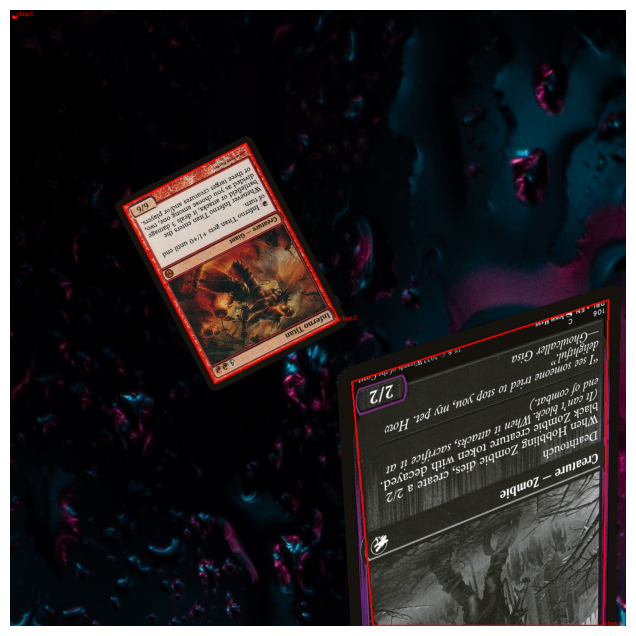

In [9]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Caminhos da imagem e do label
img_path = "/content/datasets/data/images/train/10.jpg"
label_path = "/content/datasets/data/labels/train/10.txt"

# Abrir imagem
img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)
w, h = img.size

# Ler labels e desenhar as quinas como polígono
with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) != 9:
            print(f"Ignorando linha inválida: {line.strip()}")
            continue

        try:
            coords = list(map(float, parts[1:9]))
            class_id = int(float(parts[8]))
        except ValueError:
            print(f"Erro ao converter linha: {line.strip()}")
            continue

        # Convertendo coordenadas normalizadas para pixels
        points = [(coords[i] * w, coords[i+1] * h) for i in range(0, 8, 2)]
        draw.polygon(points, outline="red", width=3)
        draw.text((points[0][0], points[0][1] - 10), f"class {class_id}", fill="red")

# Mostrar imagem
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()
